1. Analyze and Preprocess data - Check if the dataset has missing values or has any other problem.
2. Feature Engineering
3. Sampling Your Data
4. Build Model
    4. a. Try DecisionTree, RandomForest
    4. b. Try other tree-based model like: XGBoost, CatBoost
5. Perform model on training set and test set using gridsearch CV
6. Measure performance of the model.
7. Which metric is your main metric for this problem and why? What is your main model as well as their params and why?


How can I measure your point:
1. Your function is callable and runs correctly
2. The performance of your model (in full pipeline) is acceptable.
3. The data preprocessing is correct or make sense
4. The Feature engineering is correct or make sense
5. Any other additional process will be considered a small plus point.

Churn rate is a marketing metric that describes the number of customers who leave a business over a specific time period. Every user is assigned a prediction value that estimates their state of churn at any given time. This value is based on:

User demographic information
Browsing behavior
Historical purchase data among other information
It factors in our unique and proprietary predictions of how long a user will remain a customer. This score is updated every day for all users who have a minimum of one conversion. The values assigned are between 1 and 5.

# 1. Analyze and Process the data

In [1]:
!git clone https://github.com/kisejin/MachineLearningBasic.git
!pip install -U pandas_profiling
!pip install -U xlrd
!pip install feature-engine
!pip install tune-sklearn ray[tune]

Cloning into 'MachineLearningBasic'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 32 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), 6.98 MiB | 4.84 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.0/353.0 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 91.4 MB/s eta 0:00:0

In [2]:
# Change directory
import os
os.chdir('MachineLearningBasic/Tuan04')

## Load Dataset

In [3]:
# Library for data analysis
import pandas as pd
import numpy as np
import time

# Library for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# Library for data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from imblearn.pipeline import Pipeline as imbPipeline
# from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,\
                                  MinMaxScaler, StandardScaler
from feature_engine.outliers import Winsorizer

# Library for model
from sklearn.utils.metaestimators import BaseEstimator
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier

# Library for evaluate model
from sklearn.metrics import classification_report,\
                            f1_score, \
                            accuracy_score,\
                            recall_score,\
                            precision_score, confusion_matrix

# Library for optimize training
from tune_sklearn import TuneGridSearchCV
from joblib import parallel_backend
from ray.util.joblib import register_ray

<ipython-input-3-c80f97cf2e94>:9: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [4]:
pd.set_option("display.max_columns",None)

In [5]:
df=pd.read_csv('HomeWork-churn_rate_prediction.csv')
df.head(10)

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,16:08:02,17,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,16,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,14,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,Gift Vouchers/Coupons,Desktop,Mobile_Data,15:57:50,11,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,Mobile_Data,15:46:44,20,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5
5,fffe43004900440036003300320035003300,Leslie Browder,13,M,PSG1LGF,City,Gold Membership,2016-01-08,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,06:46:07,23,433.62,13884.77,24.0,722.27,Yes,No,Yes,Unsolved,No reason specified,3
6,fffe43004900440031003100360037003900,Bridget Balog,21,M,R3CX1EA,Town,Gold Membership,2015-03-19,Yes,CID24708,Gift Vouchers/Coupons,Desktop,Mobile_Data,11:40:04,10,55.38,8982.50,28.0,756.21,Yes,No,Yes,Solved in Follow-up,No reason specified,3
7,fffe4300490044003800300035003800,Herma Torgeson,42,M,4UJ1551,NaN,No Membership,2016-07-12,?,CID56614,Credit/Debit Card Offers,Both,Fiber_Optic,07:52:43,19,429.11,44554.82,24.0,568.08,No,Yes,Yes,Unsolved,Poor Product Quality,5
8,fffe43004900440033003300330032003200,Pattie Helmers,44,M,0481QNQ,Village,Silver Membership,2016-12-14,No,xxxxxxxx,Without Offers,Smartphone,Fiber_Optic,06:50:10,15,191.07,18362.31,20.0,NaN,Yes,No,Yes,Solved in Follow-up,Poor Customer Service,3
9,fffe43004900440032003000340038003300,Shaquana Leech,45,F,ZHP4MCR,Town,No Membership,2016-11-30,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,19:10:16,10,97.31,19244.16,28.0,706.23,No,Yes,Yes,No Information Available,Poor Customer Service,4


## Data Analysis

### Kiểm tra datatype của các features cũng kiểm tra xem có giá trị null hay không
Dữ liệu có giá trị null nên cần phải xử lý

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36992 non-null  object 
 1   Name                          36992 non-null  object 
 2   age                           36992 non-null  int64  
 3   gender                        36992 non-null  object 
 4   security_no                   36992 non-null  object 
 5   region_category               31564 non-null  object 
 6   membership_category           36992 non-null  object 
 7   joining_date                  36992 non-null  object 
 8   joined_through_referral       36992 non-null  object 
 9   referral_id                   36992 non-null  object 
 10  preferred_offer_types         36704 non-null  object 
 11  medium_of_operation           36992 non-null  object 
 12  internet_option               36992 non-null  object 
 13  l

### Kiểm tra giá trị null

In [7]:
df.isna().sum()

customer_id                        0
Name                               0
age                                0
gender                             0
security_no                        0
region_category                 5428
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types            288
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                3443
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

### Kiểm tra giá trị `?`

In [8]:
(df=='?').sum()

customer_id                        0
Name                               0
age                                0
gender                             0
security_no                        0
region_category                    0
membership_category                0
joining_date                       0
joined_through_referral         5438
referral_id                        0
preferred_offer_types              0
medium_of_operation             5393
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                   0
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

### Kiểm tra giá trị `Unknown`

In [9]:
(df=='Unknown').sum()

customer_id                      0
Name                             0
age                              0
gender                          59
security_no                      0
region_category                  0
membership_category              0
joining_date                     0
joined_through_referral          0
referral_id                      0
preferred_offer_types            0
medium_of_operation              0
internet_option                  0
last_visit_time                  0
days_since_last_login            0
avg_time_spent                   0
avg_transaction_value            0
avg_frequency_login_days         0
points_in_wallet                 0
used_special_discount            0
offer_application_preference     0
past_complaint                   0
complaint_status                 0
feedback                         0
churn_risk_score                 0
dtype: int64

### Kiểm tra giá trị `Error`

In [10]:
(df=='Error').sum()

customer_id                        0
Name                               0
age                                0
gender                             0
security_no                        0
region_category                    0
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types              0
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days        3522
points_in_wallet                   0
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

Có thể thấy vì một số cột xuất hiện giá trị `?`, `Unknown` hya `Error` nên thay vì datatype là int64 hoặt float64 thì lại có datatye là object, do đó ở phần preprocessing sau khi thay các giá trị trên bằng na thì em sẽ convert về đúng kiểu datatype của nó

## Preprocessing

Drop những columns có thể thấy hiển nhiên là không mang lại giá trị cho việc dự đoán (như `customer_id `, `name`,...) và những columns kiểu dữ liệu chuỗi thời gian(việc xử lý kiểu dữ liệu chuỗi thời gian là khá phức tạp và out of scope)

In [11]:
columns_to_drop=['customer_id','Name','security_no','joining_date','referral_id','last_visit_time']
df.drop(columns=columns_to_drop,axis=1,inplace=True)
df.head(5)

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18,F,Village,Platinum Membership,No,Gift Vouchers/Coupons,?,Wi-Fi,17,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,32,F,City,Premium Membership,?,Gift Vouchers/Coupons,Desktop,Mobile_Data,16,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,44,F,Town,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,14,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,37,M,City,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,11,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5
4,31,F,City,No Membership,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,20,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5


Thay giá trị `?` bằng `na`

In [12]:
df.replace('?',np.nan,inplace=True)
(df=='?').sum()

age                             0
gender                          0
region_category                 0
membership_category             0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
days_since_last_login           0
avg_time_spent                  0
avg_transaction_value           0
avg_frequency_login_days        0
points_in_wallet                0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
feedback                        0
churn_risk_score                0
dtype: int64

Thay giá trị `Unknown` bằng `na`

In [13]:
df.replace('Unknown',np.nan,inplace=True)
(df=='Unknown').sum()

age                             0
gender                          0
region_category                 0
membership_category             0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
days_since_last_login           0
avg_time_spent                  0
avg_transaction_value           0
avg_frequency_login_days        0
points_in_wallet                0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
feedback                        0
churn_risk_score                0
dtype: int64

Thay giá trị `Error` bằng `na`

In [14]:
df.replace('Error',np.nan,inplace=True)
(df=='Error').sum()

age                             0
gender                          0
region_category                 0
membership_category             0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
days_since_last_login           0
avg_time_spent                  0
avg_transaction_value           0
avg_frequency_login_days        0
points_in_wallet                0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
feedback                        0
churn_risk_score                0
dtype: int64

In [15]:
df.isna().sum()

age                                0
gender                            59
region_category                 5428
membership_category                0
joined_through_referral         5438
preferred_offer_types            288
medium_of_operation             5393
internet_option                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days        3522
points_in_wallet                3443
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

Kiểm tra thử shape của df trước vào sau khi drop na (vì không cho tham số `inplace = True` nên df vẫn không thay đổi)

In [16]:
print(df.shape)
print(df.dropna().shape)

(36992, 19)
(18737, 19)


Có thể thấy sau khi dropna thì số lượng samples giảm uống còn một nửa, mất khá nhiều dữ liệu nên em sẽ không dropna mà sẽ fillna (trình bày trong phần feature engineering)

Convert một số columns về đúng datatype của nó

In [17]:
df['avg_frequency_login_days']=df['avg_frequency_login_days'].astype('float64')

Chia các features thành các biến định tính (categorical) hoặc định lượng (numeric)

In [18]:
num_features=df.select_dtypes(include=np.number).columns[:-1]
cat_features=df.select_dtypes(include='object').columns
print(num_features)
print(cat_features)

Index(['age', 'days_since_last_login', 'avg_time_spent',
       'avg_transaction_value', 'avg_frequency_login_days',
       'points_in_wallet'],
      dtype='object')
Index(['gender', 'region_category', 'membership_category',
       'joined_through_referral', 'preferred_offer_types',
       'medium_of_operation', 'internet_option', 'used_special_discount',
       'offer_application_preference', 'past_complaint', 'complaint_status',
       'feedback'],
      dtype='object')


Tổng quan về các giá trị trong các biến định tính (categorical features)

In [19]:
for col in cat_features:
    print(df[col].value_counts(dropna=False))
    print()

F      18490
M      18443
NaN       59
Name: gender, dtype: int64

Town       14128
City       12737
NaN         5428
Village     4699
Name: region_category, dtype: int64

Basic Membership       7724
No Membership          7692
Gold Membership        6795
Silver Membership      5988
Premium Membership     4455
Platinum Membership    4338
Name: membership_category, dtype: int64

No     15839
Yes    15715
NaN     5438
Name: joined_through_referral, dtype: int64

Gift Vouchers/Coupons       12349
Credit/Debit Card Offers    12274
Without Offers              12081
NaN                           288
Name: preferred_offer_types, dtype: int64

Desktop       13913
Smartphone    13876
NaN            5393
Both           3810
Name: medium_of_operation, dtype: int64

Wi-Fi          12413
Mobile_Data    12343
Fiber_Optic    12236
Name: internet_option, dtype: int64

Yes    20342
No     16650
Name: used_special_discount, dtype: int64

Yes    20440
No     16552
Name: offer_application_preference, dtyp

## Data visualization

Biểu đồ countplot cho biến target

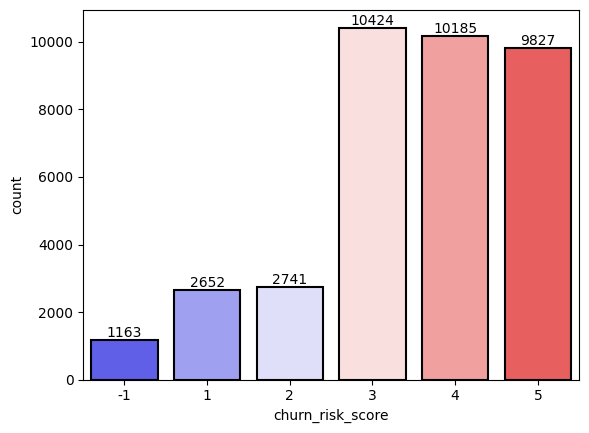

In [20]:
ax = sns.countplot(x="churn_risk_score", data=df, palette="bwr",
                   linewidth=1.5, edgecolor='black')
for label in ax.containers:
    ax.bar_label(label)

plt.show()


Có thể thấy theo mô tả thì `churn_risk_score` từ 1 đến 5, những trong data lại xuất hiện giá trị -1, em cũng không biết xử lý như thế nào nên đành giữ nguyên, coi như nó là 1 class

Và phân phối của của các class cũng không đều nhau mà chênh lệch khá nhiều, nên có thể sử dụng các phương pháp sampling

Biểu đồ histogram cho biến numeric

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'days_since_last_login'}>],
       [<Axes: title={'center': 'avg_time_spent'}>,
        <Axes: title={'center': 'avg_transaction_value'}>],
       [<Axes: title={'center': 'avg_frequency_login_days'}>,
        <Axes: title={'center': 'points_in_wallet'}>]], dtype=object)

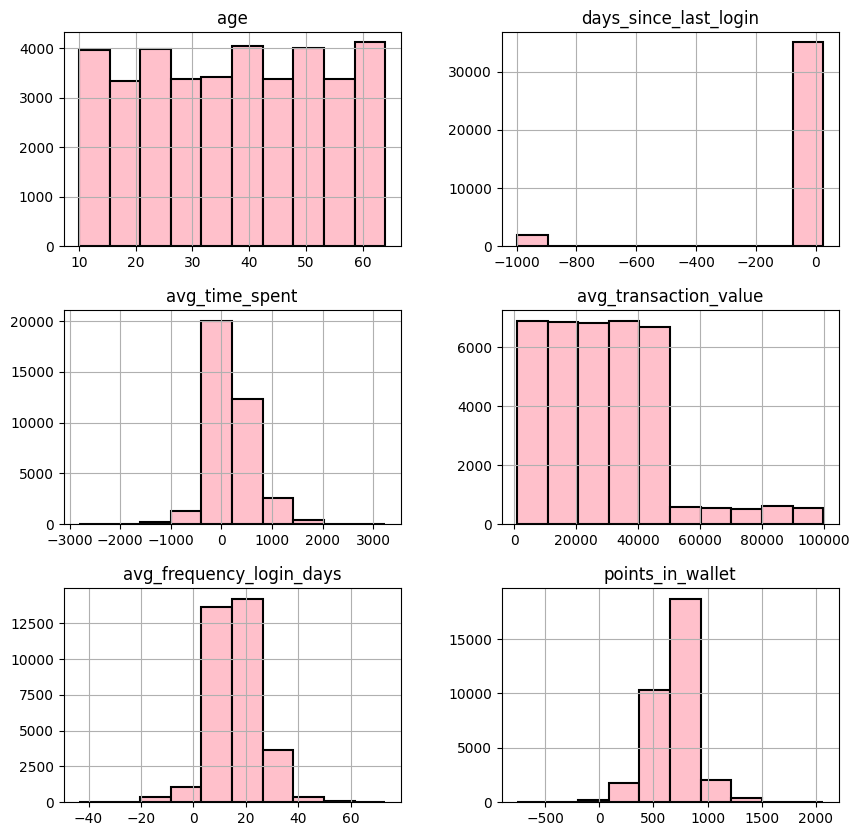

In [21]:
df.hist(column=num_features, figsize=(10, 10),
        edgecolor='black', color='pink', linewidth=1.5)

Một số cột xuất hiện giá trị < 0 , điều này khá là weird vì theo như mô tả thì giá trị của các cột này phải > 0, có thể một cơ chế nào đó của hệ thống là mặc định gán các giá trị âm cho các giá trị không xác định.

Một hướng xử lý là gán các giá trị âm là `na`, khi đó trong phần xây dựng mô hình cụ thể là imputer sẽ sử lý nó(gán cho giá trị mean), tuy nhiên vì không có đủ domain knowledge cũng như để mô hình được đơn giản thì em sẽ không xử lý vấn đề này

Biểu đồ box

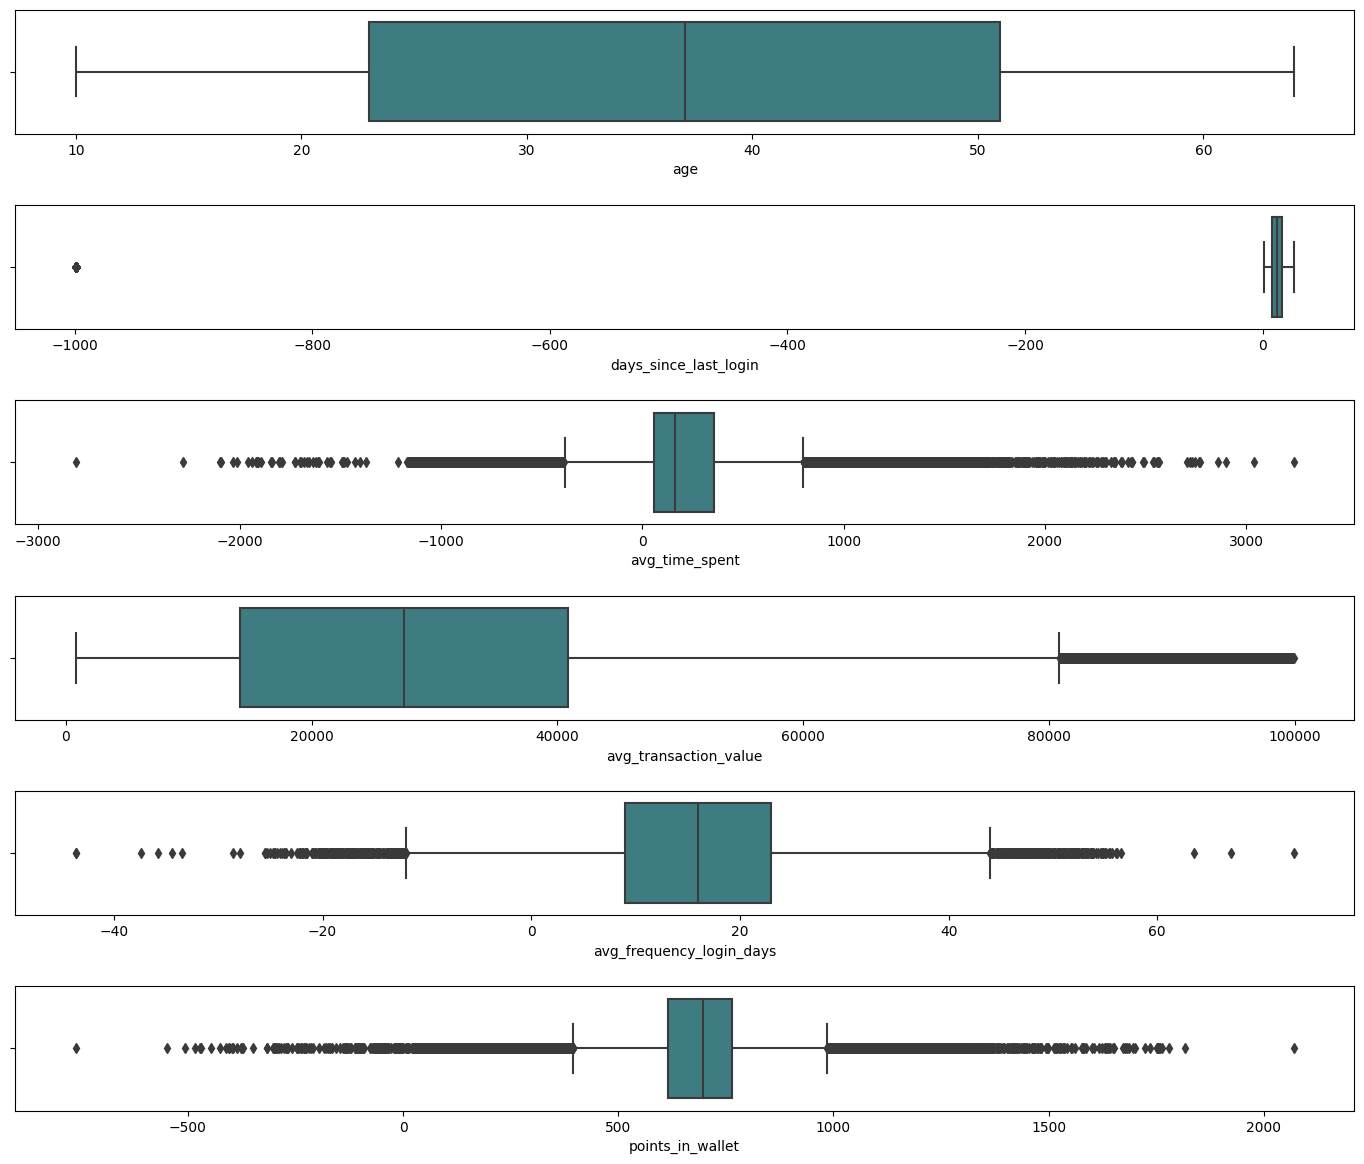

In [22]:
box_cols = num_features
fig, axes=plt.subplots(len(box_cols), 1, figsize=(14, 2*len(box_cols)),sharex=False,sharey=False)

for i, column in enumerate(box_cols):
    sns.boxplot(x=column,data=df,palette='crest',ax=axes[i])
plt.tight_layout(pad=2.0)

Biểu đồ histogram

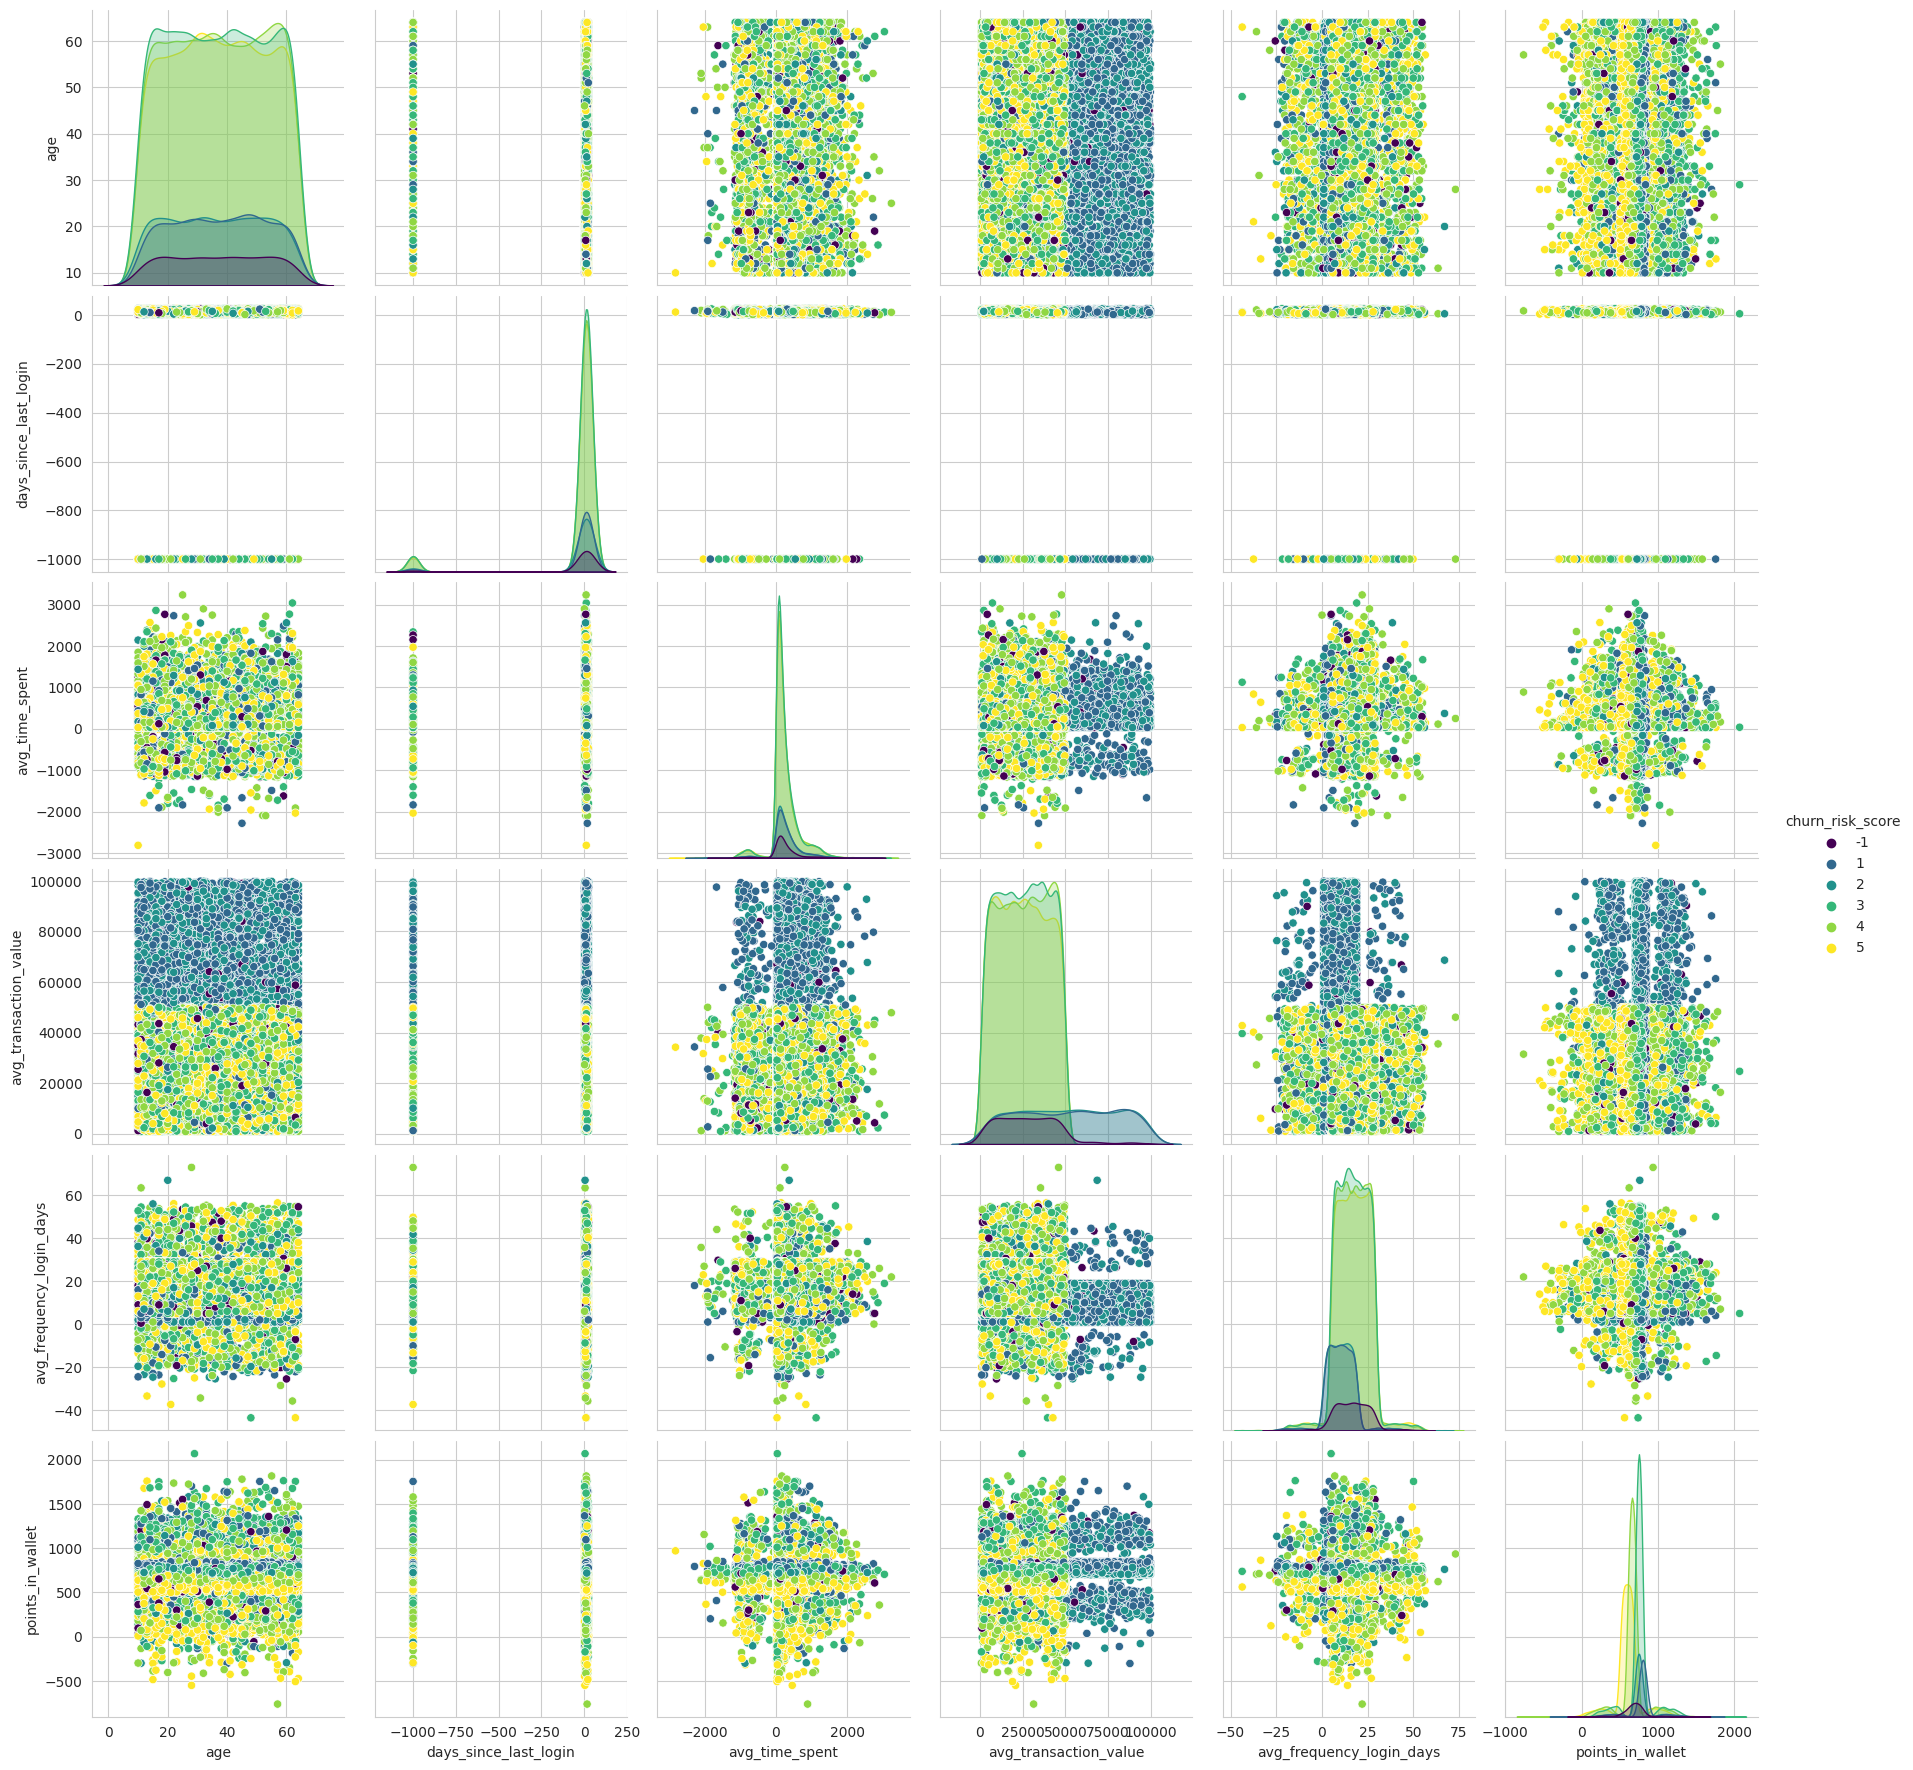

In [23]:
sns.set_style('whitegrid')
sns.pairplot(df.select_dtypes(include=np.number),
             hue = 'churn_risk_score', height = 3,
             palette = 'viridis')
plt.show()

In [24]:
# Hiển thị số giá trị âm xuất hiện trong 4 đặc trưng
display(df.loc[df['days_since_last_login']<0,['days_since_last_login']])
display(df.loc[df['avg_time_spent']<0,['avg_time_spent']])
display(df.loc[df['avg_frequency_login_days']<0,['avg_frequency_login_days']])
display(df.loc[df['points_in_wallet']<0,['points_in_wallet']])

,days_since_last_login
15,-999
57,-999
70,-999
74,-999
113,-999
...,...
36891,-999
36921,-999
36940,-999
36953,-999


,avg_time_spent
28,-936.744818
41,-930.207844
60,-615.344319
79,-687.629574
116,-494.083877
...,...
36794,-977.809108
36819,-910.568433
36956,-746.034591
36987,-650.682759


,avg_frequency_login_days
157,-12.714311
165,-1.590067
181,-13.646850
309,-5.339639
606,-15.725901
...,...
36775,-15.241874
36847,-3.530457
36879,-12.756645
36920,-9.325511


,points_in_wallet
67,-549.357498
70,-44.597633
213,-38.084314
340,-288.247333
625,-301.998780
...,...
35411,-108.057352
35883,-99.476870
35943,-43.109270
36414,-170.497210


Chuyển đổi các giá trị âm sang NaN

In [25]:
df.loc[df['days_since_last_login']<0,['days_since_last_login']]=np.nan
df.loc[df['avg_time_spent']<0,['avg_time_spent']] = np.nan
df.loc[df['avg_frequency_login_days']<0,['avg_frequency_login_days']] =np.nan
df.loc[df['points_in_wallet']<0,['points_in_wallet']]= np.nan

Biểu đồ countplot cho biến category

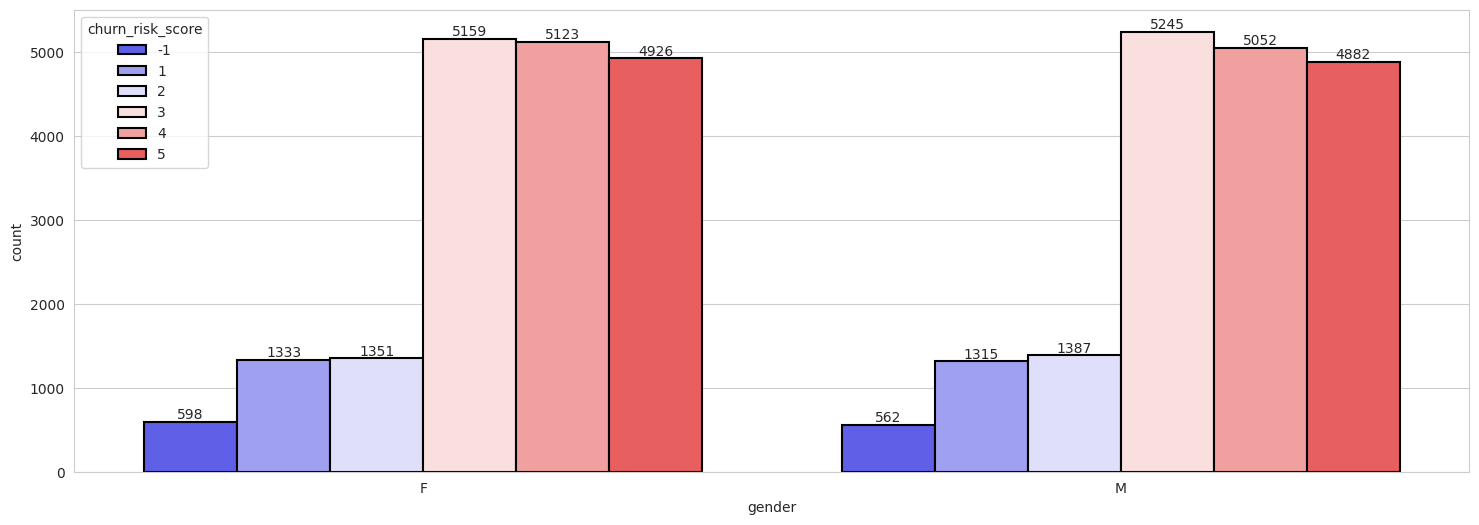

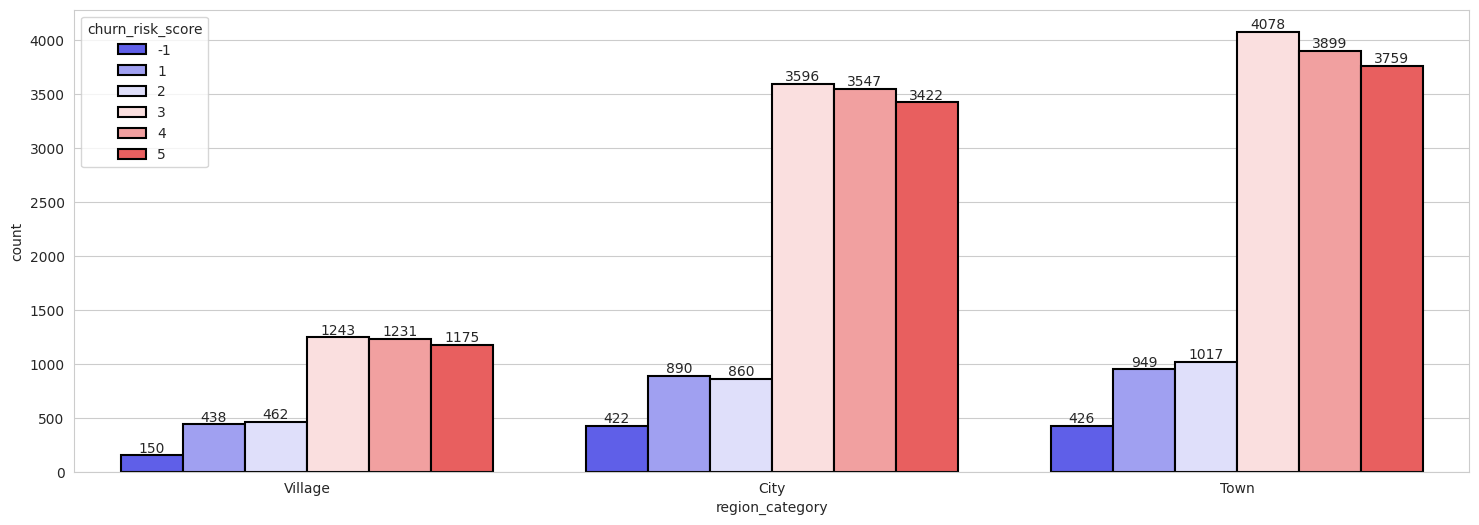

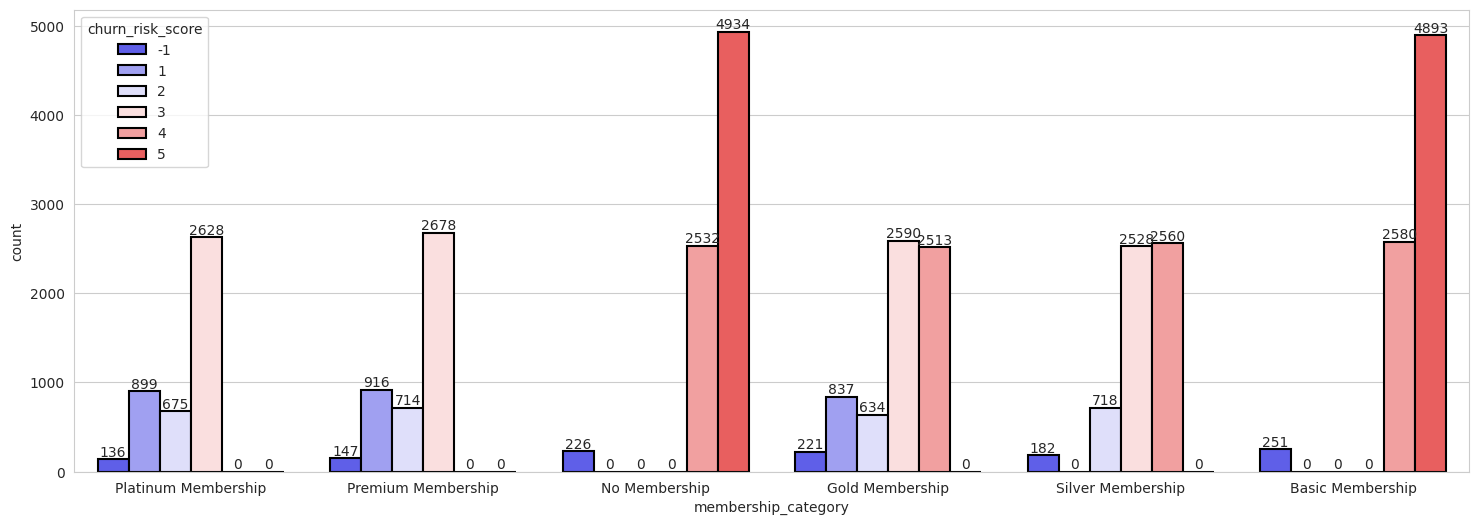

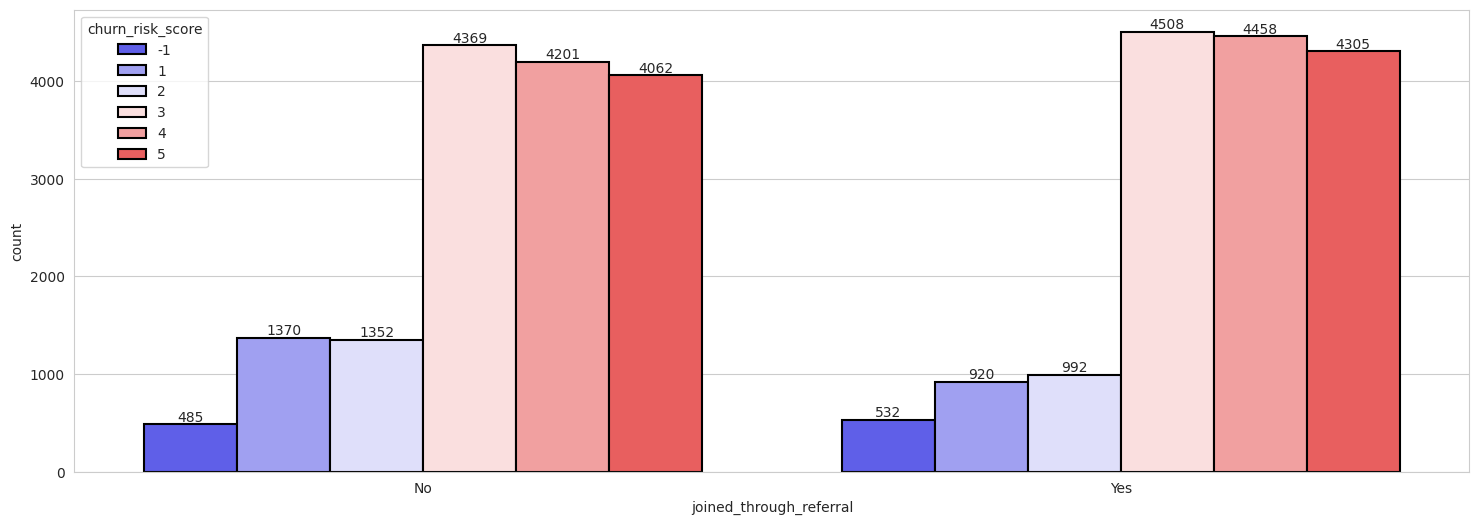

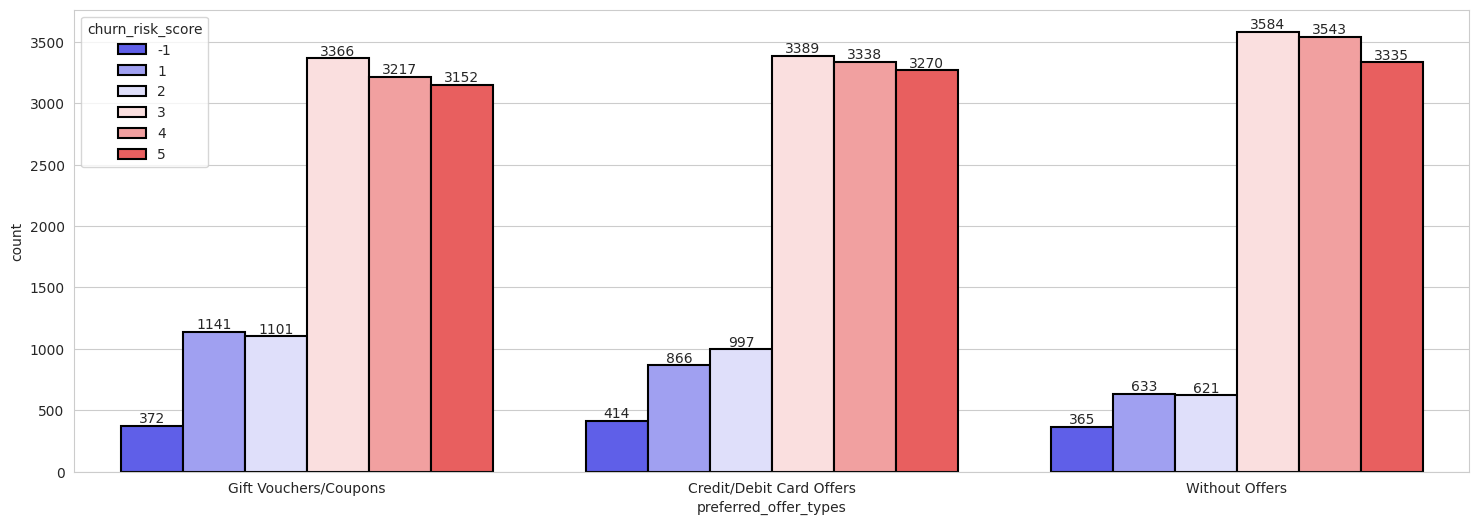

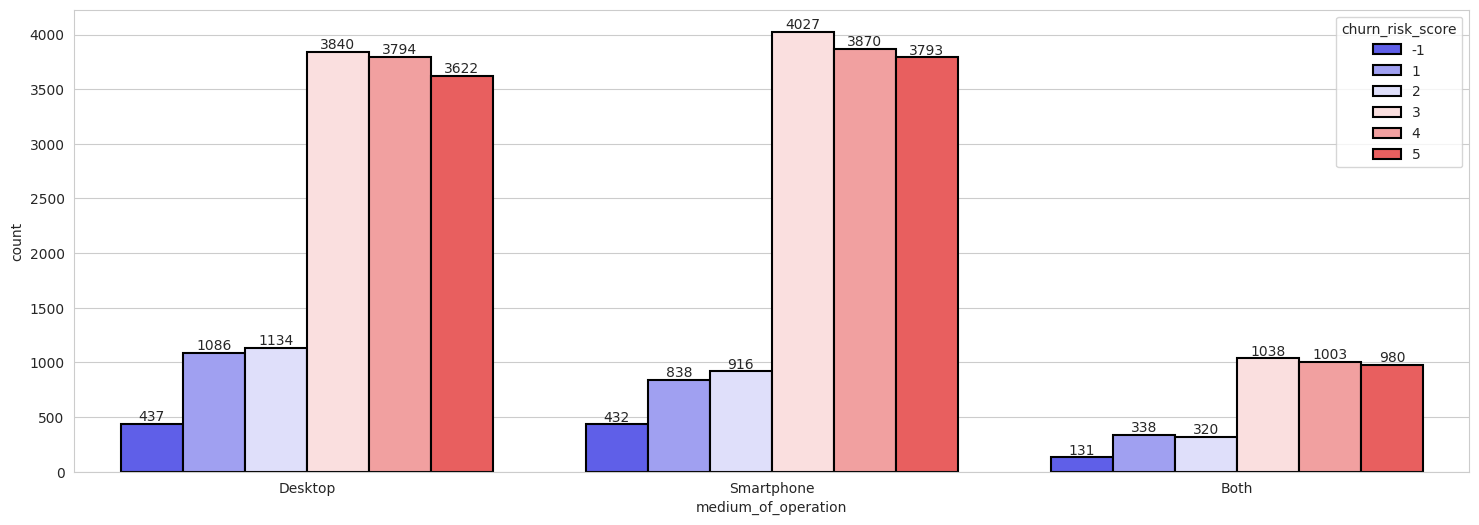

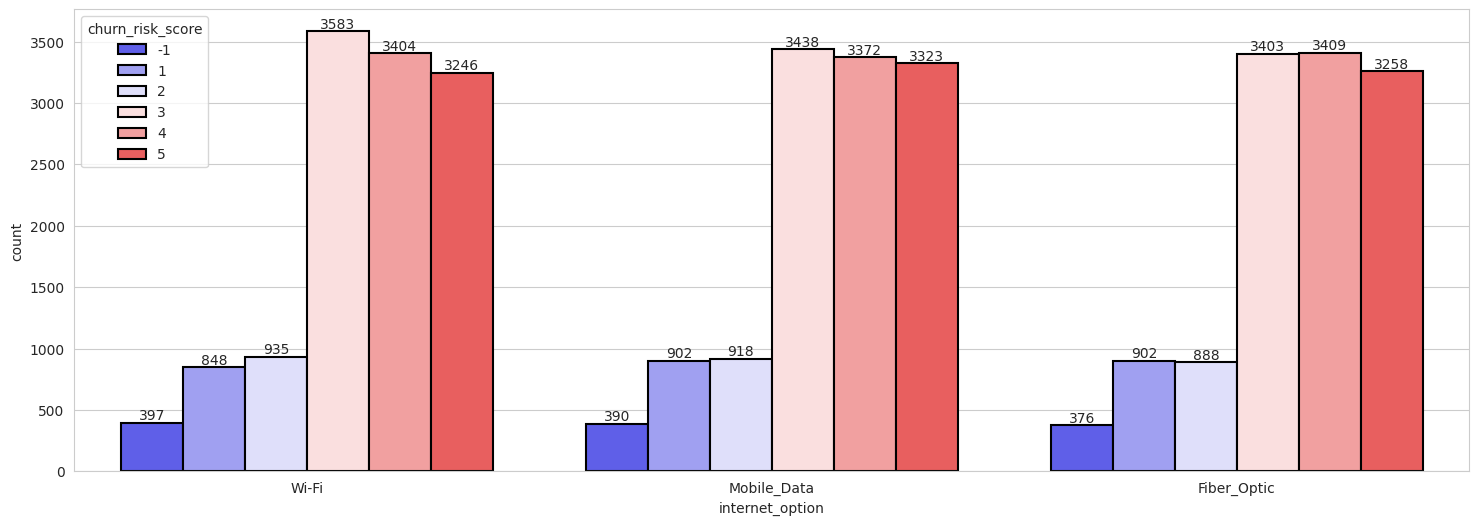

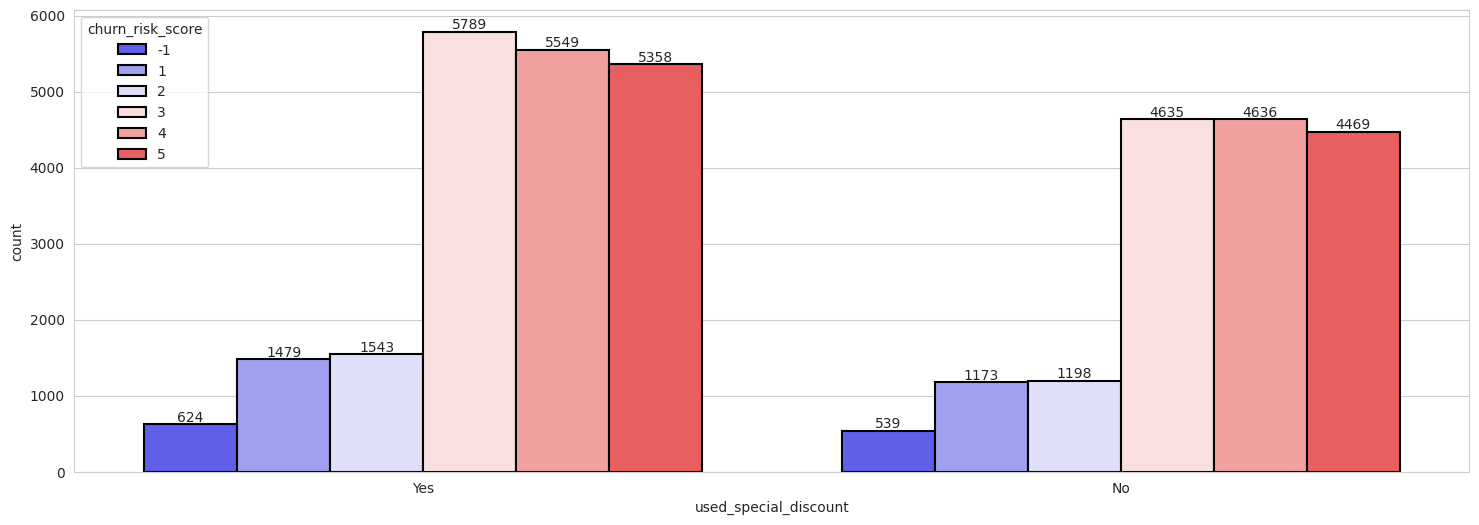

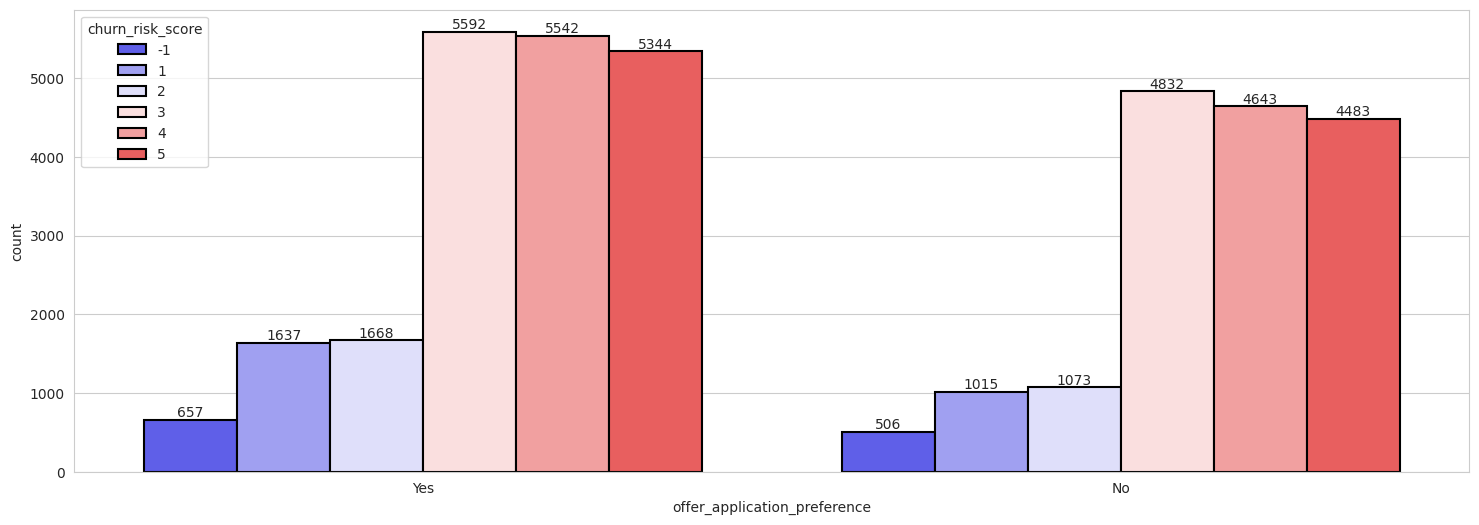

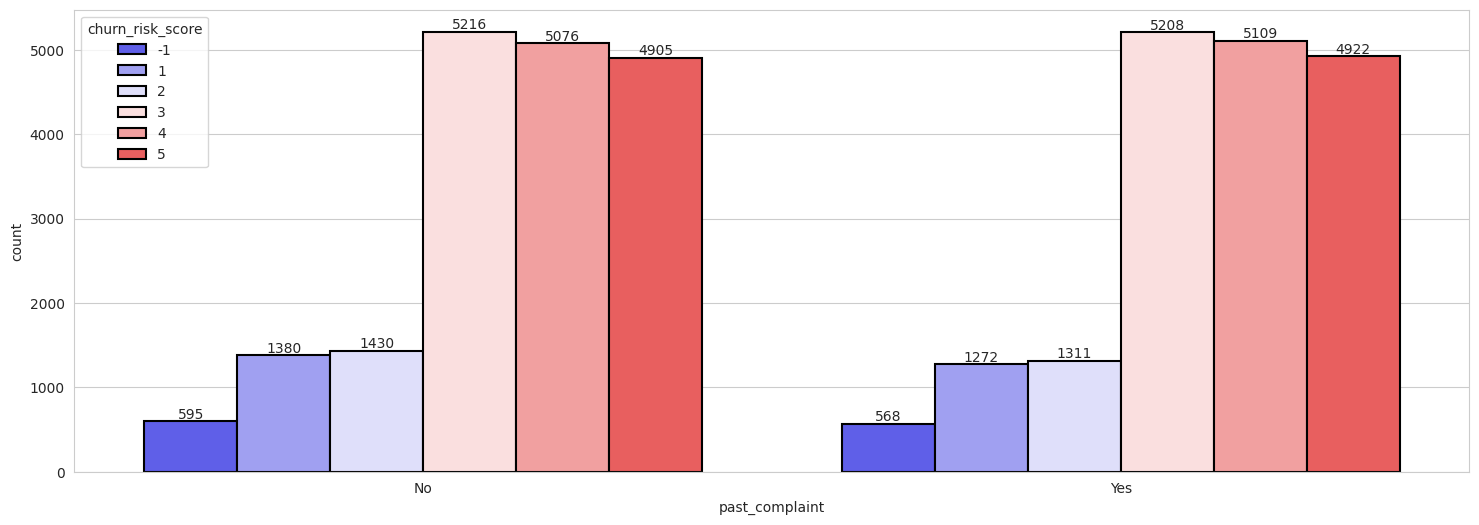

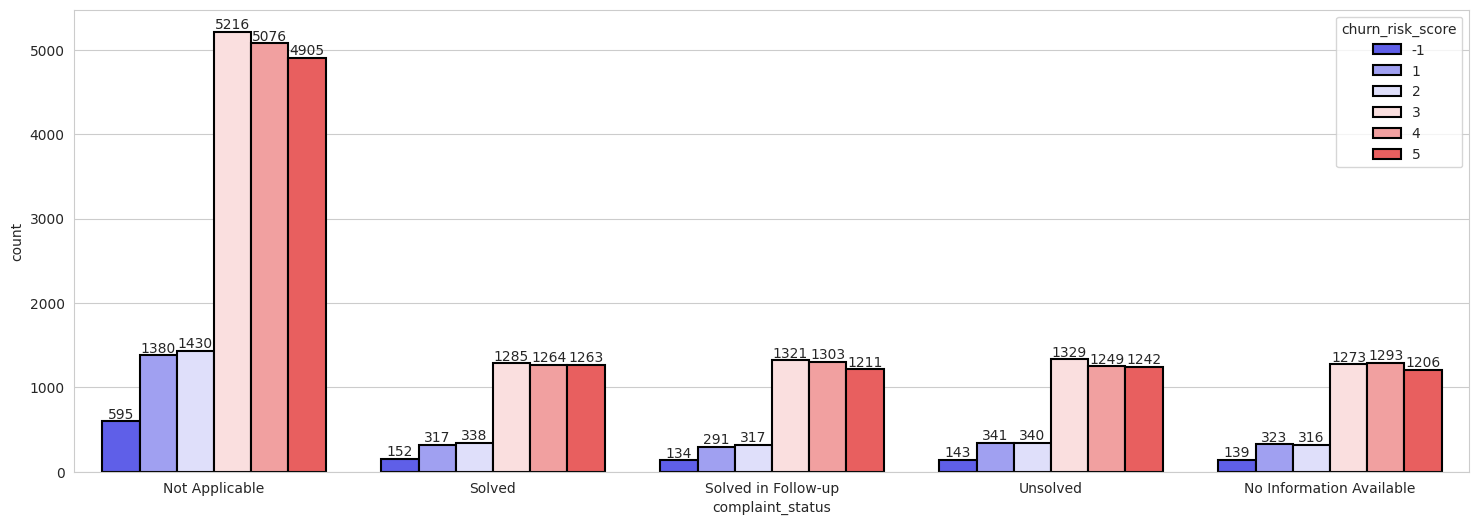

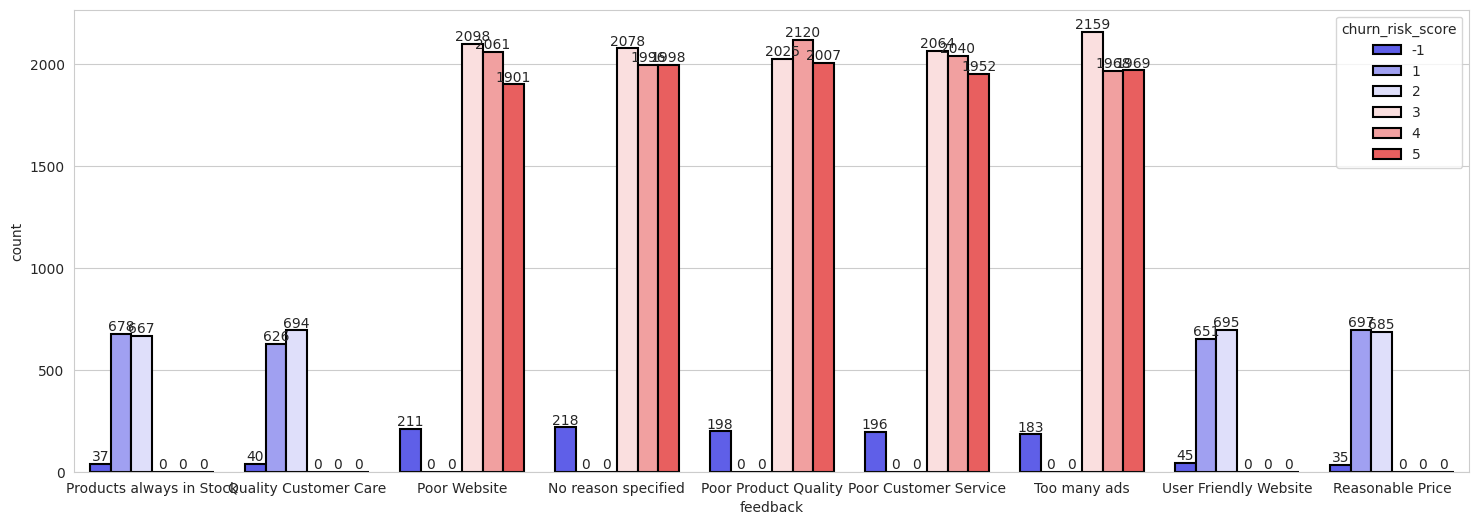

In [26]:
for i, cat_feature in enumerate(cat_features):
    plt.figure(figsize=(18,6))
    ax=sns.countplot(x=cat_feature, data=df, palette="bwr",
                   hue='churn_risk_score', linewidth=1.5, edgecolor='black')
    for label in ax.containers:
        ax.bar_label(label)

Hàm tạo feature và target

In [27]:
def prepare_X_y(df):
    """
    Feature engineering and create X and y
    :param df: pandas dataframe
    :return: (X, y) output feature matrix (dataframe), target (series)
    """
    # Todo: Split data into X and y (using sklearn train_test_split). Return two dataframes
    X =  df[df.columns[:-1]]
    y =  df[df.columns[-1]]
    return X, y


Chia train, test set

In [28]:
RANDOM_STATE = 20
TRAIN_SIZE = 0.75

X0, y0 = prepare_X_y(df)
trainX0, testX0 ,trainY0, testY0 = train_test_split(X0, y0, train_size=TRAIN_SIZE, random_state=RANDOM_STATE,stratify=y0)

Các phần như feature engineering hay sampling đều được xây dựng trong pipeline nên em sẽ gộp chung các phần này vào phần xây dựng mô hình

# 2. Feature engineering
# 3. Sampling Your Data
# 4. Build Model
# 5. Perform model on training set and test set using gridsearch CV
# 6. Measure performance of the model.

In [29]:
np.set_printoptions(suppress=True)

## Xây dựng hàm build_model

In [30]:
def build_model(X, y,pipeline, param_grid):

    # Tạo GridSearchCV
    grid_search = TuneGridSearchCV(
        pipeline,  # Mô hình được sử dụng
        param_grid,  # Các tham số cần tìm kiếm
        cv=5,  # Số lượng fold trong cross-validation
        scoring='f1_weighted',  # Độ đo sử dụng để đánh giá mô hình
        n_jobs = -1, # Sử dụng tài nguyên chưa sử dụng để train model
        return_train_score=True, # Trả về score trong quá trình training với tham số dược fine-tuning
    )

    register_ray()
    with parallel_backend("ray"):
      grid_search.fit(X, y)
    return grid_search


## Xây dựng Pileline

In [31]:
numeric_transformer = Pipeline(
    steps=[
            ("imputer", SimpleImputer(strategy='mean')),
            ('outlier', Winsorizer(capping_method = 'gaussian', tail = 'both',
                                      fold = 3, missing_values = 'ignore')),
            ("scaler", StandardScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer",SimpleImputer(strategy='most_frequent')),
        ("encoder", OneHotEncoder(handle_unknown="infrequent_if_exist"))
    ]
)
# Tạo đối tượng preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num",numeric_transformer,num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)


## Mô hình 0 (LinearSVC)

In [66]:
estimator=LinearSVC()

# Tạo Pipeline
pipeline = Pipeline(steps=[
    ('column_transformer', preprocessor),
    ('estimator', estimator)
])

param_grid={
    "estimator__C":[0.01,0.1,1,10,100]
}

model = build_model(trainX0, trainY0,pipeline,param_grid)
model.fit(trainX0, trainY0)

# Compare on training dataset
pred = model.predict(trainX0)
print('Train : \n')
print(classification_report(trainY0,pred))
pred = model.predict(testX0)
print('Test : \n')
print(classification_report(testY0,pred))
print(f'Best score: {f1_score(testY0, pred, average = "weighted")}')

/usr/local/lib/python3.10/dist-packages/ray/tune/tune.py:258: UserWarning: Passing a `local_dir` is deprecated and will be removed in the future. Pass `storage_path` instead or set the`RAY_AIR_LOCAL_CACHE_DIR` environment variable instead.
  warnings.warn(
(_Trainable pid=23522) /usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(_Trainable pid=23522)   warnings.warn(
(_Trainable pid=23525)   warnings.warn(
(_Trainable pid=23525)   warnings.warn(
(_Trainable pid=23522) /usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(_Trainable pid=23522)   warnings.warn(
(_Trainable pid=23525)   warnings.warn(
(_Trainable pid=23525)   warnings.warn(
(_Trainable pid=23522) /usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the 

Train : 

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       872
           1       0.57      0.88      0.69      1989
           2       0.76      0.40      0.53      2056
           3       0.82      0.86      0.84      7818
           4       0.68      0.33      0.45      7639
           5       0.64      1.00      0.78      7370

    accuracy                           0.69     27744
   macro avg       0.58      0.58      0.55     27744
weighted avg       0.68      0.69      0.66     27744

Test : 

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       291
           1       0.55      0.88      0.68       663
           2       0.73      0.36      0.48       685
           3       0.81      0.86      0.84      2606
           4       0.67      0.32      0.44      2546
           5       0.64      1.00      0.78      2457

    accuracy                           0.69      9248
   m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Vì kết quả dự đoán class -1 rất thấp (=0), có nghĩa là các features không có ý nghĩa trong việc dự đoán class -1. Có thể class -1 là sai sót trong quá trình thu thập dữ liệu, hoặc có thể là vì một lý do nào đó. Vì mô tả của dữ liệu không có thông tin rõ ràng về các class, nên cũng khó khăn trong việc xác định được hành vi của các class là như thế nào. Em sẽ thử drop đi class -1 và chạy lại các mô hình với các class từ 1 đến 5

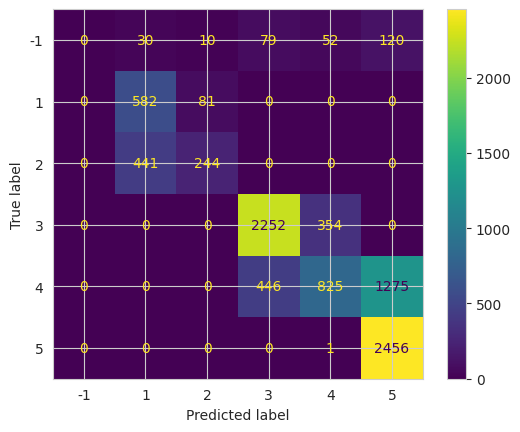

In [68]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ConfusionMatrixDisplay(confusion_matrix(testY0,pred),display_labels=model.classes_).plot()

## Loại bỏ class -1 ra khỏi dataset

In [35]:
df_core = df.copy()
df_core = df_core[df_core['churn_risk_score'] != - 1]
X1, y1 = prepare_X_y(df_core)
trainX1, testX1 ,trainY1, testY1 = train_test_split(X1, y1, train_size=TRAIN_SIZE, random_state=RANDOM_STATE,stratify=y1)

## Mô hình 1 (SVC linear kernel)

In [60]:

# estimator=SGDClassifier(n_jobs=-1)
estimator=LinearSVC()

# Tạo Pipeline
pipeline = Pipeline(steps=[
    ('column_transformer', preprocessor),
    ('estimator', estimator)
])

param_grid={
    "estimator__C":[0.01,0.1,1,10,100]
}

In [61]:
model1 = build_model(trainX1, trainY1,pipeline,param_grid)
# Compare on training dataset
pred = model1.predict(trainX1)
print('Train : \n')
print(classification_report(trainY1,pred))
pred = model1.predict(testX1)
print('Test : \n')
print(classification_report(testY1,pred))
print(f'Best parameter : {model1.best_params_}')
print(f'Best score: {f1_score(testY1, pred, average = "weighted")}')

/usr/local/lib/python3.10/dist-packages/ray/tune/tune.py:258: UserWarning: Passing a `local_dir` is deprecated and will be removed in the future. Pass `storage_path` instead or set the`RAY_AIR_LOCAL_CACHE_DIR` environment variable instead.
  warnings.warn(
(_Trainable pid=21898)   warnings.warn(
(_Trainable pid=21898)   warnings.warn(
(_Trainable pid=21931) /usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(_Trainable pid=21931)   warnings.warn(
(_Trainable pid=21931) /usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations. [repeated 2x across cluster]
(_Trainable pid=21931)   warnings.warn( [repeated 2x across cluster]
(_Trainable pid=21898) /usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations. 

Train : 

              precision    recall  f1-score   support

           1       0.58      0.89      0.70      1989
           2       0.78      0.38      0.51      2056
           3       0.86      0.87      0.87      7818
           4       0.73      0.35      0.47      7638
           5       0.66      1.00      0.79      7370

    accuracy                           0.72     26871
   macro avg       0.72      0.70      0.67     26871
weighted avg       0.74      0.72      0.69     26871

Test : 

              precision    recall  f1-score   support

           1       0.59      0.89      0.71       663
           2       0.79      0.39      0.52       685
           3       0.84      0.87      0.86      2606
           4       0.72      0.34      0.46      2547
           5       0.66      1.00      0.79      2457

    accuracy                           0.72      8958
   macro avg       0.72      0.70      0.67      8958
weighted avg       0.73      0.72      0.69      8958

Bes

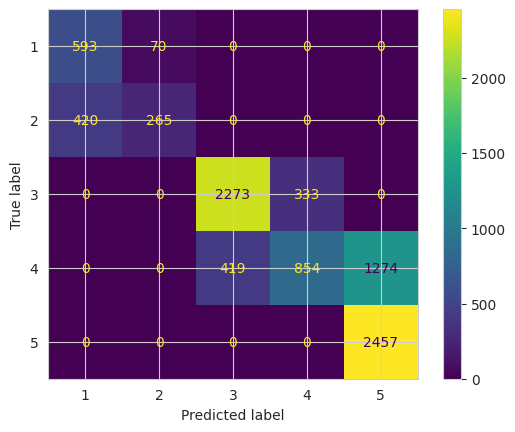

In [62]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ConfusionMatrixDisplay(confusion_matrix(testY1,pred),display_labels=model1.classes_).plot()

## Mô hình 2 (SVC với linear, sử dụng StochasticGradientDescent)

In [63]:
estimator=SGDClassifier(n_jobs=-1, loss = 'hinge', early_stopping = True)

# Tạo Pipeline
pipeline = Pipeline(steps=[
    ('column_transformer', preprocessor),
    ('estimator', estimator)
])

param_grid={
    "estimator__alpha":[0.01,0.1,1,10,100],

}

model2 = build_model(trainX1, trainY1,pipeline,param_grid)
# Compare on training dataset
pred = model2.predict(trainX1)
print('Train : \n')
print(classification_report(trainY1,pred))
pred = model2.predict(testX1)
print('Test : \n')
print(classification_report(testY1,pred))
print(f'Best parameter : {model2.best_params_}')
print(f"Best score: {f1_score(testY1, pred, average = 'weighted')}")

/usr/local/lib/python3.10/dist-packages/ray/tune/tune.py:258: UserWarning: Passing a `local_dir` is deprecated and will be removed in the future. Pass `storage_path` instead or set the`RAY_AIR_LOCAL_CACHE_DIR` environment variable instead.
  warnings.warn(


Train : 

              precision    recall  f1-score   support

           1       0.57      1.00      0.73      1989
           2       1.00      0.27      0.42      2056
           3       0.67      1.00      0.80      7818
           4       0.00      0.00      0.00      7638
           5       0.66      1.00      0.79      7370

    accuracy                           0.66     26871
   macro avg       0.58      0.65      0.55     26871
weighted avg       0.49      0.66      0.54     26871

Test : 

              precision    recall  f1-score   support

           1       0.56      1.00      0.72       663
           2       1.00      0.25      0.40       685
           3       0.67      1.00      0.80      2606
           4       0.00      0.00      0.00      2547
           5       0.66      1.00      0.79      2457

    accuracy                           0.66      8958
   macro avg       0.58      0.65      0.54      8958
weighted avg       0.49      0.66      0.54      8958

Bes

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

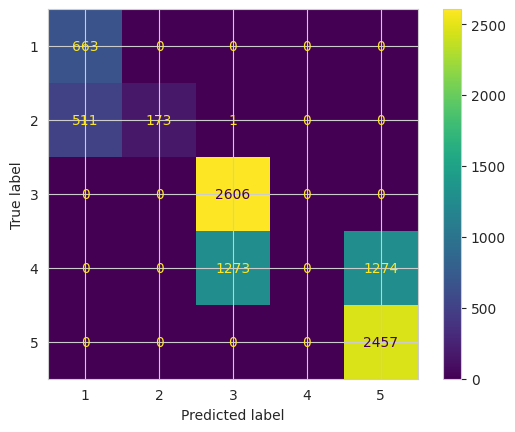

In [64]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ConfusionMatrixDisplay(confusion_matrix(testY1,pred),display_labels=model2.classes_).plot()

## Mô hình 3 (SVC với rbf kernel)

In [ ]:
estimator=SVC(tol=1e-2, class_weight = 'balanced')

# Tạo Pipeline
pipeline = Pipeline(steps=[
    ('column_transformer', preprocessor),
    ('estimator', estimator)
])

param_grid={
    "estimator__C":[0.01,0.1,1,10,100],
}

model3 = build_model(trainX1, trainY1,pipeline,param_grid)

In [58]:
# Compare on training dataset
pred = model3.predict(trainX1)
print('Train : \n')
print(classification_report(trainY1,pred))
pred = model3.predict(testX1)
print('Test : \n')
print(classification_report(testY1,pred))
print(f'Best parameter : {model3.best_params_}')
print(f"Best score: {f1_score(testY1, pred, average = 'weighted')}")

Train : 

              precision    recall  f1-score   support

           1       0.58      0.93      0.71      1989
           2       0.84      0.34      0.48      2056
           3       0.92      0.88      0.90      7818
           4       0.77      0.42      0.55      7638
           5       0.66      1.00      0.79      7370

    accuracy                           0.74     26871
   macro avg       0.75      0.71      0.69     26871
weighted avg       0.77      0.74      0.72     26871

Test : 

              precision    recall  f1-score   support

           1       0.57      0.92      0.71       663
           2       0.82      0.33      0.47       685
           3       0.90      0.86      0.88      2606
           4       0.74      0.40      0.52      2547
           5       0.66      1.00      0.79      2457

    accuracy                           0.73      8958
   macro avg       0.74      0.70      0.67      8958
weighted avg       0.76      0.73      0.71      8958

Bes

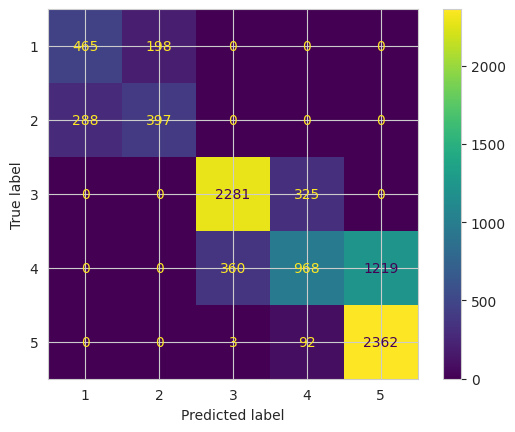

In [57]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ConfusionMatrixDisplay(confusion_matrix(testY1,pred),display_labels=model3.classes_).plot()

## Mô hình 4 (SVC với polynomial kernel)

In [53]:
estimator=SVC(tol=1e-2, class_weight = 'balanced', kernel = 'poly')

# Tạo Pipeline
pipeline = Pipeline(steps=[
    ('column_transformer', preprocessor),
    ('estimator', estimator)
])

param_grid={
    "estimator__C":[0.01,0.1,1,10],
    'estimator__degree': [2,3]
}

model4 = build_model(trainX1, trainY1,pipeline,param_grid)
# Compare on training dataset
pred = model4.predict(trainX1)
print('Train : \n')
print(classification_report(trainY1,pred))
pred = model4.predict(testX1)
print('Test : \n')
print(classification_report(testY1,pred))
print(f'Best parameter : {model4.best_params_}')
print(f"Best score: {f1_score(testY1, pred, average = 'weighted')}")

/usr/local/lib/python3.10/dist-packages/ray/tune/tune.py:258: UserWarning: Passing a `local_dir` is deprecated and will be removed in the future. Pass `storage_path` instead or set the`RAY_AIR_LOCAL_CACHE_DIR` environment variable instead.
  warnings.warn(


Train : 

              precision    recall  f1-score   support

           1       0.83      0.90      0.86      1989
           2       0.90      0.82      0.86      2056
           3       0.92      0.92      0.92      7818
           4       0.82      0.46      0.59      7638
           5       0.68      0.99      0.80      7370

    accuracy                           0.80     26871
   macro avg       0.83      0.82      0.81     26871
weighted avg       0.82      0.80      0.79     26871

Test : 

              precision    recall  f1-score   support

           1       0.62      0.70      0.66       663
           2       0.67      0.58      0.62       685
           3       0.86      0.88      0.87      2606
           4       0.70      0.38      0.49      2547
           5       0.66      0.96      0.78      2457

    accuracy                           0.72      8958
   macro avg       0.70      0.70      0.68      8958
weighted avg       0.73      0.72      0.70      8958

Bes

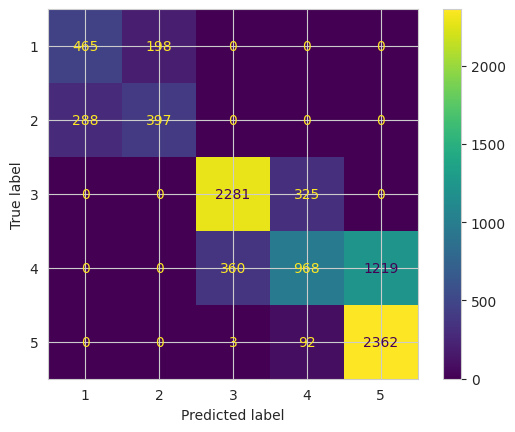

In [56]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ConfusionMatrixDisplay(confusion_matrix(testY1,pred),display_labels=model4.classes_).plot()

# 7. Conclusion

* Vì trường hợp multiclass và các class có support chênh lệch nhau nhiều nên em sử dụng f1_weighted là main score để đánh giá mô hình

* Trong tất cả các mô hình thì chủ yếu là giữa Class 1 và 2, 4 và 5 bị miss classified khá nhiều , còn lại các mô hình dự đoán khá tốt

* Thời gian chạy SVC tăng phi tuyến với số lượng samples, vì dữ liệu khá lớn nên sẽ mất nhiều thời gian để training

* Vì kết quả dự đoán class -1 rất thấp (=0), có nghĩa là các features không có ý nghĩa trong việc dự đoán class -1. Có thể class -1 là sai sót trong quá trình thu thập dữ liệu, hoặc có thể là vì một lý do nào đó. Hoặc -1 là giá trị mặc định khi khách hàng không đánh giá sản phẩm.

* Kết quả nhân được:

| Model | Score |
| :--- | :--- |
| 1. Linear SVC | 0.69 |
| 2. SGD Linear SVC | 0.54 |
| 3. RBF SVC | 0.71 |
| 4. Polynomial SVC | 0.70 |